Note: ChatGPT was utilized for coding.

"ChatGPT: Markov switching forecasting issues,” “ChatGPT: Real-time forecasting with AR," "ChatGPT: Overlay plot with shading.”  ChatGPT. [Online] Available: https://chatgpt.com/share/67f186e6-be48-8005-829b-0cf38c07c1f6, https://chatgpt.com/share/67f08ee9-9390-8005-877d-0d078b4adeab, https://chatgpt.com/share/67f18721-6500-8005-b89d-4c7e05fb6db7


Other sources referred to:

“Time-series-analysis/model selection.ipynb at master · ritvikmath/time-series-
analysis,” GitHub. (), [Online]. Available: https://github.com/ritvikmath/Time-Series-Analysis/blob/master/Model%20Selection.ipynb.

“Time-series-analysis/VAR model.ipynb at master · ritvikmath/time-series-analysis,”
GitHub. (), [Online]. Available: https://github.com/ritvikmath/Time-Series-Analysis/blob/master/VAR%20Model.ipynb.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.api import VAR, MarkovAutoregression

# 1. AR(2) - No Re-Train

i. Setup

In [ ]:
# Read GDP File
df_gdp = pd.read_csv('rGDP_JS.csv')
df_gdp['observation_date'] = pd.to_datetime(df_gdp.observation_date)
df_gdp.set_index('observation_date', inplace=True)

In [ ]:
# Determine Training and Testing Period
train_start = pd.to_datetime("1984/7/1")
train_end = pd.to_datetime("2005/4/1")
df_train = df_gdp[train_start:train_end]

test_start = pd.to_datetime("2005/7/1")
test_end = pd.to_datetime("2016/10/1")
df_test = df_gdp[test_start:test_end]

ii. Model Parameterization and Fitting

In [ ]:
# Select Lag Based on AIC Information Criteria and the Fit Model
lag_selection = ar_select_order(df_train,8,ic='aic')
model_fit = AutoReg(df_train['rGDP'].copy(), lags=lag_selection.ar_lags).fit()
print(model_fit.summary())
print('Lag Selection: ', lag_selection.ar_lags)

                            AutoReg Model Results                             
Dep. Variable:                   rGDP   No. Observations:                   84
Model:                     AutoReg(2)   Log Likelihood                 -54.585
Method:               Conditional MLE   S.D. of innovations              0.471
Date:                Wed, 09 Apr 2025   AIC                            117.170
Time:                        07:16:56   BIC                            126.797
Sample:                    01-01-1985   HQIC                           121.035
                         - 04-01-2005                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4341      0.117      3.723      0.000       0.206       0.663
rGDP.L1        0.1760      0.107      1.653      0.098      -0.033       0.385
rGDP.L2        0.2773      0.107      2.600      0.0

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


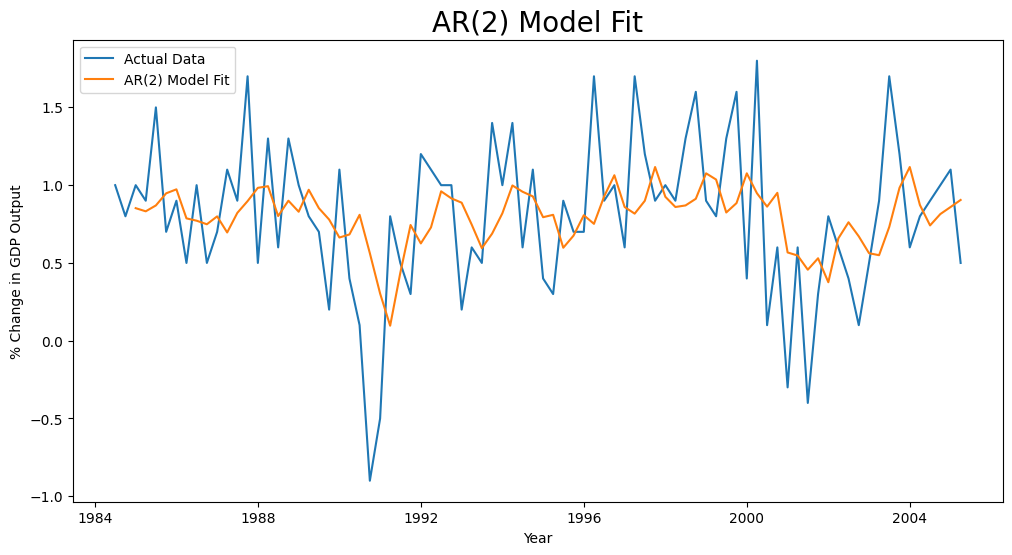

In [ ]:
# Plotting
plt.figure(figsize=(12, 6))
plt.title("AR(2) Model Fit", fontsize='20')
plt.xlabel("Year")
plt.ylabel("% Change in GDP Output")

plt.plot(df_train)
plt.plot(model_fit.fittedvalues)
plt.legend(('Actual Data', 'AR(2) Model Fit'))

iii. Model Forecasting

In [ ]:
# Predict Forward
predictions_ar = model_fit.predict(start = test_start, end = test_end)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


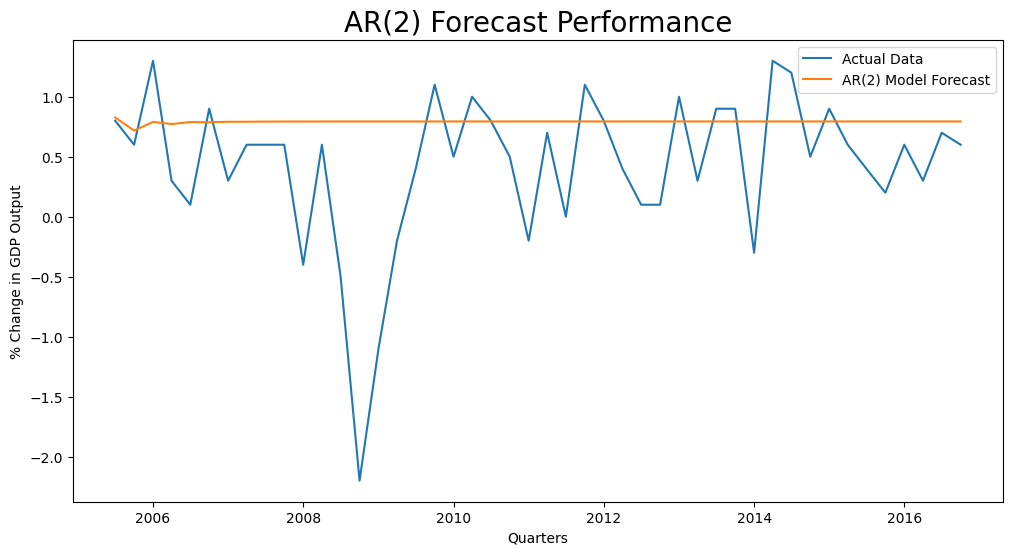

In [ ]:
# Plotting
plt.figure(figsize=(12, 6))
plt.title("AR(2) Forecast Performance", fontsize='20')
plt.xlabel("Quarters")
plt.ylabel("% Change in GDP Output")

plt.plot(df_test)
plt.plot(predictions_ar)
plt.legend(('Actual Data', 'AR(2) Model Forecast'))

In [ ]:
df_test_np = df_test['rGDP'].to_numpy()
predictions_np = predictions_ar.to_numpy()
print('2-Norm Error: ', np.linalg.norm(predictions_np - df_test_np))

2-Norm Error:  4.920555628761256


# 2. AR - Re-Train

i. Setup

In [ ]:
# Read GDP File
df_gdp = pd.read_csv('rGDP_JS.csv')
df_gdp['observation_date'] = pd.to_datetime(df_gdp.observation_date)
df_gdp.set_index('observation_date', inplace=True)

In [ ]:
# Determine Training and Testing Period
train_start = pd.to_datetime("1984/7/1")
train_end = pd.to_datetime("2005/4/1")
df_train = df_gdp[train_start:train_end]

test_start = pd.to_datetime("2005/7/1")
test_end = pd.to_datetime("2016/10/1")
df_test = df_gdp[test_start:test_end]

ii. Model Parameterization, Fitting, and Forecasting

In [ ]:
# Select Lag Based on AIC Information Criteria and the Fit Model
lag_selection = ar_select_order(df_train,8,ic='aic')
lag_selection.ar_lags

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


[1, 2]

In [ ]:
# Refit Model Every Quarter
predictions_ar_refit = []
window = df_train['rGDP'].copy()

for date, new_val in df_test['rGDP'].items():

    # Select New Lag Every Quarter
    lag_selection = ar_select_order(window,10,ic='aic')

    # Refit Model Every Quarter and Predict Next Quarter
    model_fit = AutoReg(window, lags=lag_selection.ar_lags).fit()
    nextPrediction = model_fit.predict(start=len(window), end=len(window))[0]
    predictions_ar_refit.append((date, nextPrediction))

    # Update Available Data Window Period
    window.loc[date] = new_val

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
<ipython-input-598-4cf9007a

In [ ]:
# Prepare Data to Plot
df_predictions_ar_refit = pd.DataFrame(predictions_ar_refit, columns=["observation_date", "prediction"])
df_predictions_ar_refit.set_index("observation_date", inplace=True)

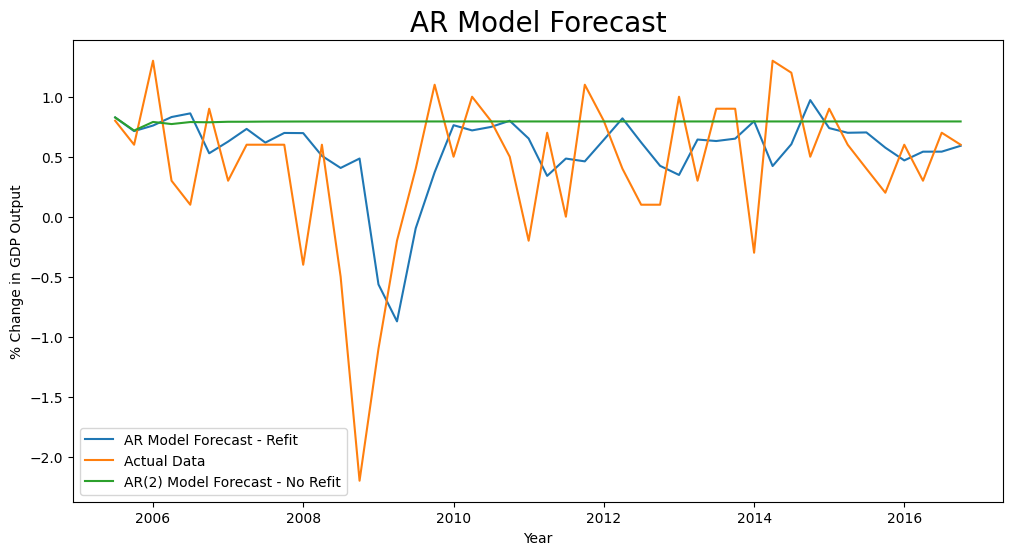

In [ ]:
# Plotting
plt.figure(figsize=(12, 6))
plt.xlabel("Year")
plt.ylabel("% Change in GDP Output")
plt.title("AR Model Forecast", fontsize=20)
plt.plot(df_predictions_ar_refit)
plt.plot(df_test)
plt.plot(predictions_ar)
plt.legend(('AR Model Forecast - Refit', 'Actual Data', 'AR(2) Model Forecast - No Refit'))

In [ ]:
print('2-Norm Error: ', np.linalg.norm(df_predictions_ar_refit['prediction'].to_numpy() - df_test['rGDP'].to_numpy()))

2-Norm Error:  4.255157699882041


# 3. VAR(7)

i. Setup

In [ ]:
# Read GDP and Indicators File
df_gdp = pd.read_csv('VARData copy.csv')
df_gdp['observation_date'] = pd.to_datetime(df_gdp.observation_date)
df_gdp.set_index('observation_date', inplace=True)

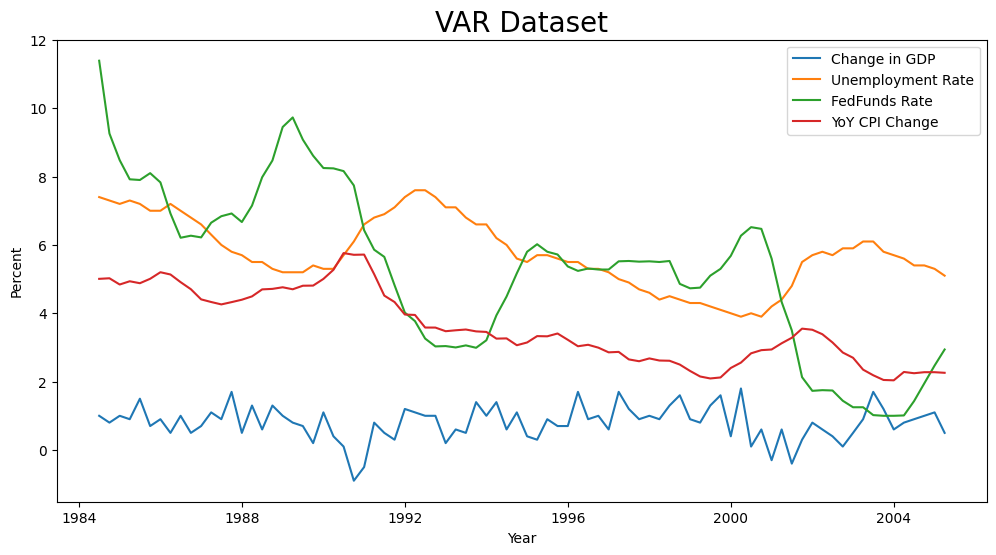

In [ ]:
# Plotting Dataset
plt.figure(figsize=(12, 6))
plt.plot(df_gdp[train_start:train_end])
plt.title('VAR Dataset', fontsize='20')
plt.xlabel('Year')
plt.ylabel('Percent')
plt.legend(('Change in GDP', 'Unemployment Rate','FedFunds Rate','YoY CPI Change'))

In [ ]:
# Determine Training and Testing Period
train_start = pd.to_datetime("1984/7/1")
train_end = pd.to_datetime("2005/4/1")
df_train = df_gdp[train_start:train_end]

test_start = pd.to_datetime("2005/7/1")
test_end = pd.to_datetime("2016/10/1")
df_test = df_gdp[test_start:test_end]

ii. Model Parameterization and Fitting

In [ ]:
# Select Lag Based on AIC Information Criteria and the Fit Model
model = VAR(df_train)
model_fit = model.fit(ic = 'aic')
print("Lags Selected: ", model_fit.k_ar)

Lags Selected:  11


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


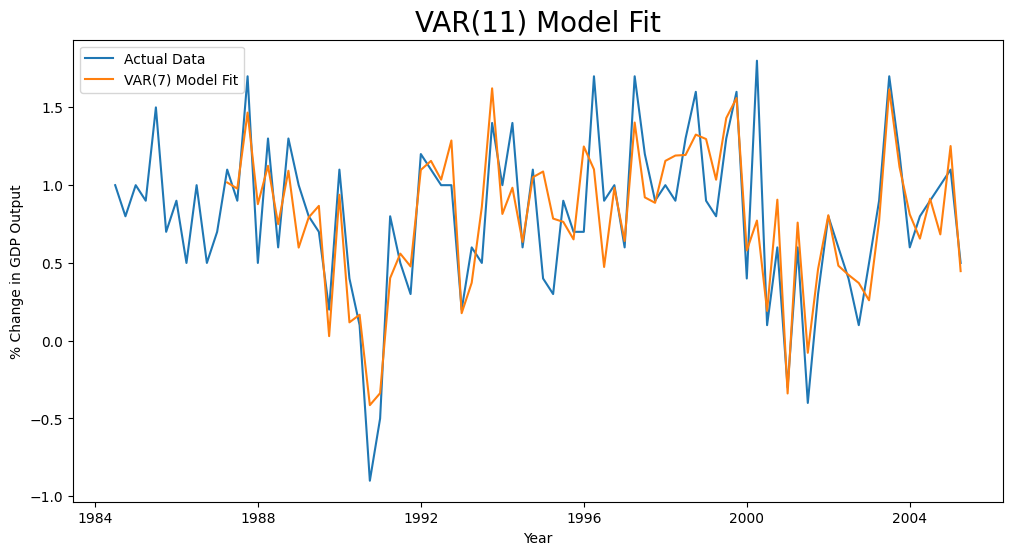

In [ ]:
# Plotting
plt.figure(figsize=(12, 6))
plt.title("VAR(11) Model Fit", fontsize='20')
plt.xlabel("Year")
plt.ylabel("% Change in GDP Output")

plt.plot(df_train[['rGDP']])
plt.plot(model_fit.fittedvalues[['rGDP']])
plt.legend(('Actual Data', 'VAR(7) Model Fit'))

iii. Model Forecasting

In [ ]:
# Predict Forward
np_train = df_train.to_numpy()
predictions_var = model_fit.forecast(np_train,len(df_test))

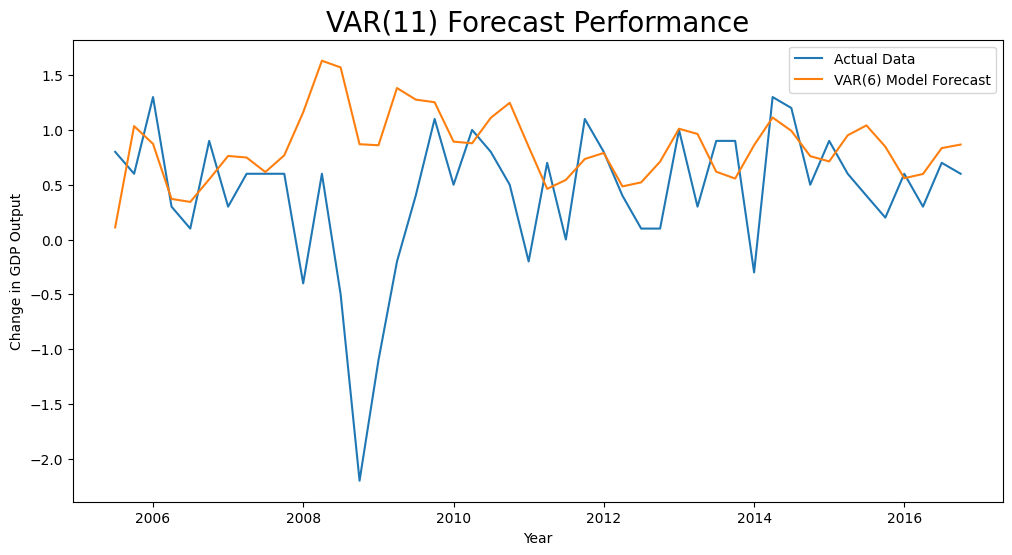

In [ ]:
# Plotting
plt.figure(figsize=(12, 6))
plt.title("VAR(11) Forecast Performance", fontsize='20')
plt.xlabel("Year")
plt.ylabel("Change in GDP Output")

plt.plot(df_test['rGDP'])
plt.plot(df_test.index, predictions_var[:,0])
plt.legend(('Actual Data', 'VAR(6) Model Forecast'))

In [ ]:
df_test_np = df_test['rGDP'].to_numpy()
print('2-Norm Error: ', np.linalg.norm(predictions_var[:,0] - df_test_np))

2-Norm Error:  5.648368720525314


# 4. VAR - Re-Train

i. Setup

In [ ]:
# Read GDP and Indicators File
df_gdp = pd.read_csv('VARData copy.csv')
df_gdp['observation_date'] = pd.to_datetime(df_gdp.observation_date)
df_gdp.set_index('observation_date', inplace=True)

In [ ]:
# Determine Training and Testing Period
train_start = pd.to_datetime("1984/7/1")
train_end = pd.to_datetime("2005/4/1")
df_train = df_gdp[train_start:train_end]

test_start = pd.to_datetime("2005/7/1")
test_end = pd.to_datetime("2016/10/1")
df_test = df_gdp[test_start:test_end]

ii. Model Parameterization, Fitting, and Forecasting

In [ ]:
# Refit Model Every Quarter
predictions_var_refit = []
window = df_train.copy()

for date, new_row in df_test.iterrows():

    # Select New Lag Every Quarter and Fit Model
    model = VAR(window)
    model_fit = model.fit(ic = 'aic')

    # Predict Next Quarter
    input_data = window.values[-model_fit.k_ar:]
    nextPrediction = model_fit.forecast(input_data, steps=1)[0]
    predictions_var_refit.append((date, nextPrediction[0]))

    # Update Available Data Window Period
    window.loc[date] = new_row

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be use

In [ ]:
# Prepare Data to Plot
df_predictions_var_refit = pd.DataFrame(predictions_var_refit, columns=["obseration_date", "prediction"]).set_index("obseration_date")

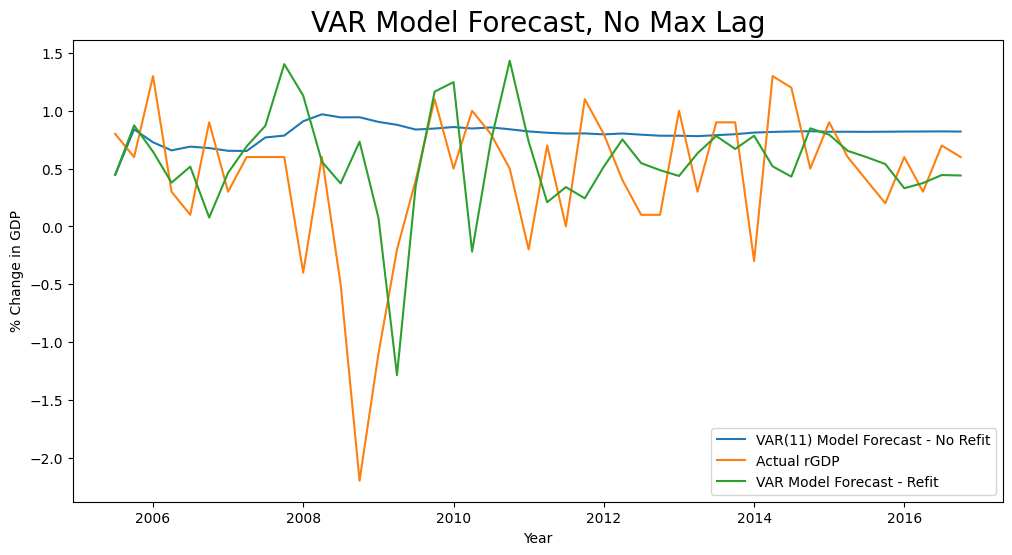

In [ ]:
plt.figure(figsize=(12, 6))
plt.title("VAR Model Forecast, No Max Lag", fontsize=20)
plt.plot(df_test.index, predictions_var[:,0], label='VAR(11) Model Forecast - No Refit')
plt.plot(df_test['rGDP'], label='Actual rGDP')
plt.plot(df_predictions_var_refit['prediction'], label='VAR Model Forecast - Refit')
plt.xlabel("Year")
plt.ylabel("% Change in GDP")
plt.legend()
plt.show()

In [ ]:
np.linalg.norm(df_predictions_var_refit['prediction'].to_numpy() - df_test['rGDP'].to_numpy())

np.float64(5.027581218782826)

# 5. MS-AR(4)

i. Setup

In [ ]:
# Read GDP File
df_gdp = pd.read_csv('rGDP_JS.csv')
df_gdp['observation_date'] = pd.to_datetime(df_gdp.observation_date)
df_gdp.set_index('observation_date', inplace=True)

In [ ]:
# Determine Training and Testing Period
train_start = pd.to_datetime("1984/7/1")
train_end = pd.to_datetime("2005/4/1")
df_train = df_gdp[train_start:train_end]

test_start = pd.to_datetime("2005/7/1")
test_end = pd.to_datetime("2016/10/1")
df_test = df_gdp[test_start:test_end]

ii. Model Parameterization and Fitting

In [ ]:
ms = MarkovAutoregression(df_train, k_regimes = 2, order = 4, switching_ar=False)
ms_model = ms.fit()
ms_model.summary()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                         Markov Switching Model Results                         
================================================================================
Dep. Variable:                     rGDP   No. Observations:                   80
Model:             MarkovAutoregression   Log Likelihood                 -53.024
Date:                  Wed, 09 Apr 2025   AIC                            124.048
Time:                          04:44:00   BIC                            145.486
Sample:                      07-01-1984   HQIC                           132.643
                           - 04-01-2005                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7885      0.494      1.597      0.110      -0.179       1.756
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7885      0.442      1.784      0.074      -0.078       1.655
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.2204      0.035      6.325      0.000       0.152       0.289
ar.L1          0.2256      0.112      2.021      0.043       0.007       0.444
ar.L2          0.2647      0.113      2.334      0.020       0.042       0.487
ar.L3         -0.1521      0.113     -1.342      0.180      -0.374       0.070
ar.L4          0.1124      0.112      1.006      0.314      -0.107       0.331
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.4532        nan        nan        nan         nan         nan
p[1->0]        0.4445        nan        nan        nan         nan         nan
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

Text(0.5, 0, 'Observation Date')

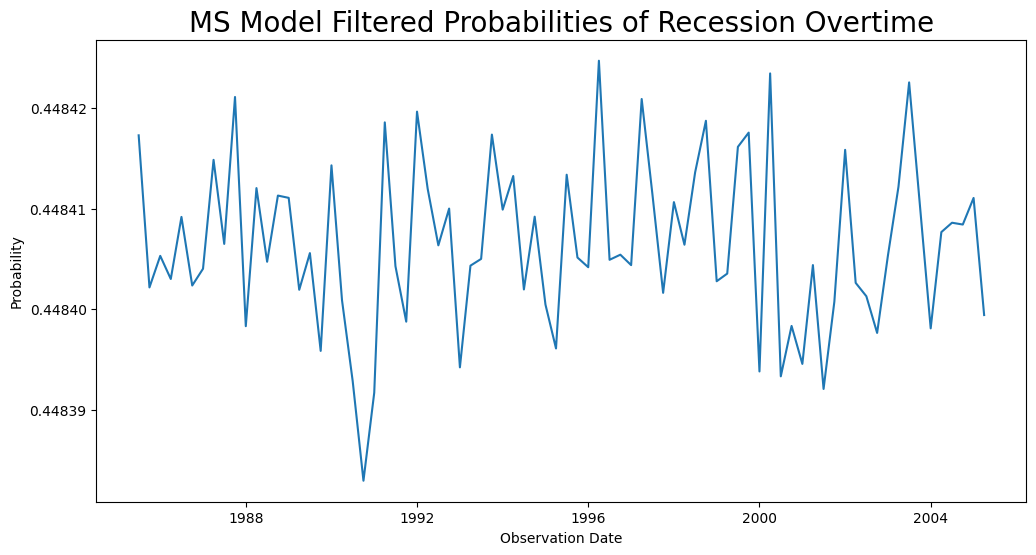

In [ ]:
# Plot Filtered Probability Graph
plt.figure(figsize=(12, 6))
plt.plot(ms_model.filtered_marginal_probabilities[0])
plt.title('MS Model Filtered Probabilities of Recession Overtime',fontsize='20')
plt.ylabel('Probability')
plt.xlabel('Observation Date')

Text(0.5, 0, 'Observation Date')

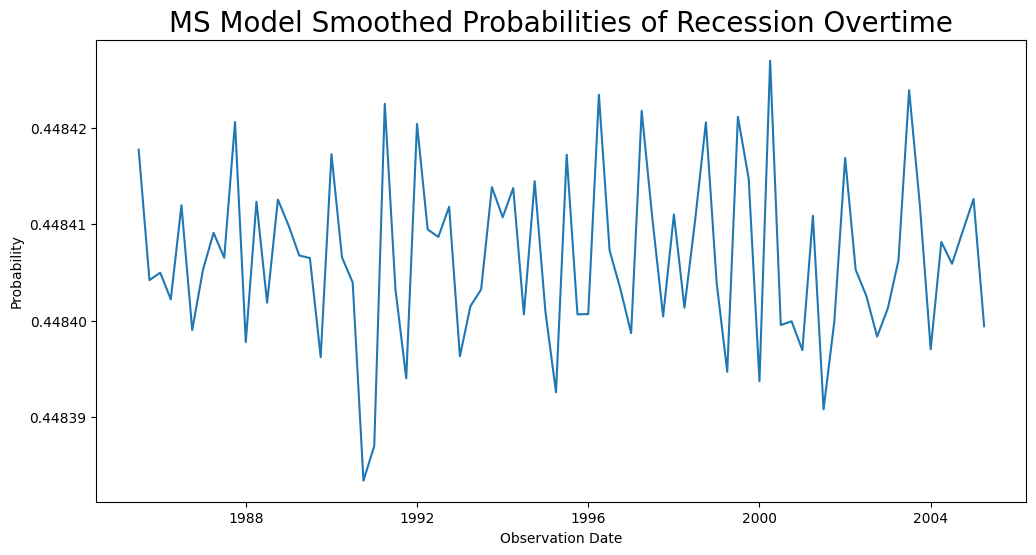

In [ ]:
# Plot Smoothed Probability Graph
plt.figure(figsize=(12, 6))
plt.plot(ms_model.smoothed_marginal_probabilities[0])
plt.title('MS Model Smoothed Probabilities of Recession Overtime', fontsize='20')
plt.ylabel('Probability')
plt.xlabel('Observation Date')

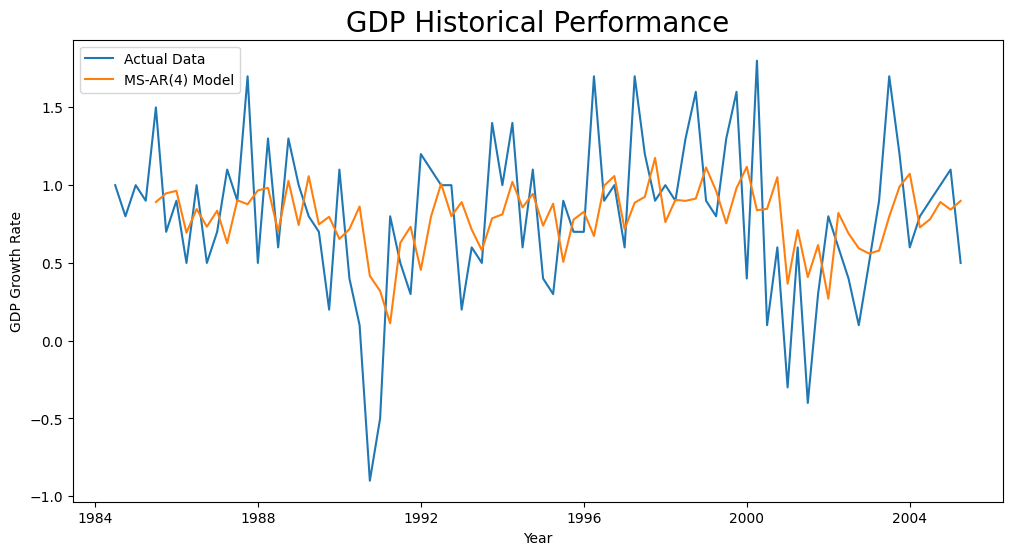

In [ ]:
# Plotting Fitted Graph
plt.figure(figsize=(12, 6))
plt.title("GDP Historical Performance", fontsize='20')
plt.xlabel("Year")
plt.ylabel("GDP Growth Rate")

plt.plot(df_train)
plt.plot(ms_model.fittedvalues)
plt.legend(('Actual Data', 'MS-AR(4) Model'))

iii. Model Forecast

In [ ]:
ms_model.params

,0
p[0->0],0.453193
p[1->0],0.444515
const[0],0.788484
const[1],0.788468
sigma2,0.220407
ar.L1,0.225586
ar.L2,0.264713
ar.L3,-0.152137
ar.L4,0.112402


In [ ]:
# Transition Probabilites
p_00 = ms_model.params[0]
p_01 = 1 - ms_model.params[0]
p_10 = ms_model.params[1]
p_11 = 1 - ms_model.params[1]

# Other Model Parameters
p_sT_0 = ms_model.filtered_marginal_probabilities.iloc[-1][0]
p_sT_1 = ms_model.filtered_marginal_probabilities.iloc[-1][1]
mu_0 = ms_model.params[2]
mu_1 = ms_model.params[3]
a = np.array((ms_model.params[5],ms_model.params[6],ms_model.params[7],ms_model.params[8]))
T = len(ms_model.fittedvalues)

<ipython-input-413-53fc034688dd>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_00 = ms_model.params[0]
<ipython-input-413-53fc034688dd>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_01 = 1 - ms_model.params[0]
<ipython-input-413-53fc034688dd>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_10 = ms_model.params[1]
<ipython-input-413-53fc034688dd>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecat

In [ ]:
# Model Parameters
h = len(df_test)
lags = 4

# Known Mean (T-lags+1,...,T)
mean = np.zeros(lags + h)
for i in range(lags):
  mean[lags - 1 - i] = mu_0 * ms_model.smoothed_marginal_probabilities.iloc[-1-i][0] + mu_1 * ms_model.smoothed_marginal_probabilities.iloc[-1-i][1]

# Predicted Mean (T+h s.t h>0)
pred_reg_probabilities_0 = (p_00 * p_sT_0) + (p_10 * p_sT_1)
pred_reg_probabilities_1 = (p_01 * p_sT_0) + (p_11 * p_sT_1)
pred_mean = (mu_0 * pred_reg_probabilities_0) + (mu_1 * pred_reg_probabilities_1)
for i in range(h):
  mean[lags+i] = pred_mean # always a constant predicted mean for h > 0 as model is not refitted

# Build Historical Y Values
y = np.zeros(lags + h)
for i in range(lags):
  y[lags - 1 - i] = df_train.iloc[-1-i][0]

# Build Prediction Y Values (h>0)
for i in range(h):
  hold = 0
  for j in range(lags):
    hold = hold + (a[j]*(y[lags-1+i-j] - mean[lags-1+i-j]))
  y[lags+i] = mean[lags+i] + hold

<ipython-input-414-a952db58fde6>:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y[lags - 1 - i] = df_train.iloc[-1-i][0]


Text(0, 0.5, 'Change in GDP Output')

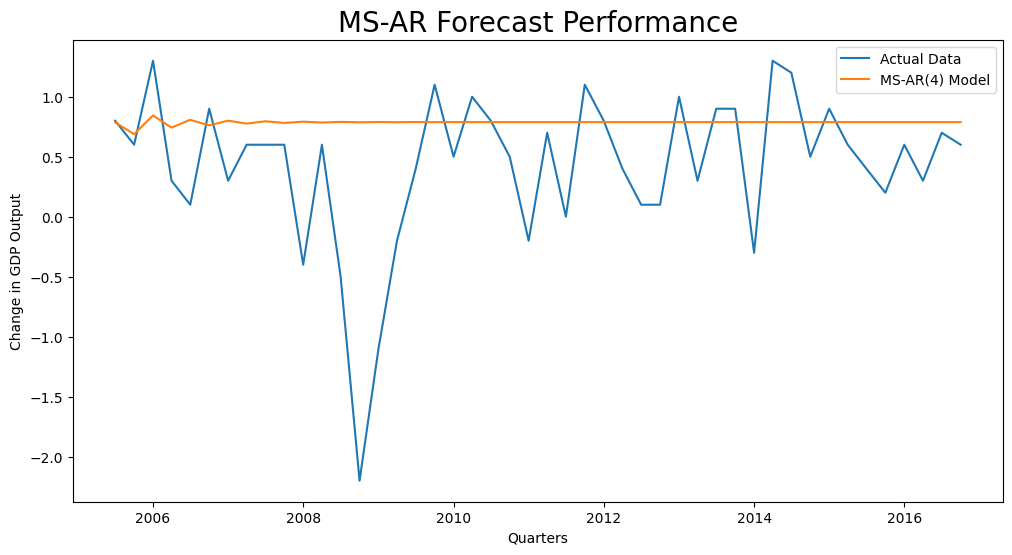

In [ ]:
# Plotting
plt.figure(figsize=(12, 6))
plt.title("MS-AR Forecast Performance", fontsize='20')
plt.xlabel("Quarters")
plt.plot(df_test.index,df_test)
plt.plot(df_test.index,y[lags:])
plt.legend(('Actual Data', 'MS-AR(4) Model'))
plt.ylabel("Change in GDP Output")

In [ ]:
df_test_np = df_test['rGDP'].to_numpy()
print('2-Norm Error: ', np.linalg.norm(y[lags:] - df_test_np))

2-Norm Error:  4.899361790670977


# 6. MS-AR(4) - Re-fit

i. Model Setup

In [ ]:
# Read GDP File
df_gdp = pd.read_csv('rGDP_JS.csv')
df_gdp['observation_date'] = pd.to_datetime(df_gdp.observation_date)
df_gdp.set_index('observation_date', inplace=True)

In [ ]:
# Determine Training and Testing Period
train_start = pd.to_datetime("1984/7/1")
train_end = pd.to_datetime("2005/4/1")
df_train = df_gdp[train_start:train_end]

test_start = pd.to_datetime("2005/7/1")
test_end = pd.to_datetime("2016/10/1")
df_test = df_gdp[test_start:test_end]

ii. Model Parameterization, Fitting, and Forecasting

In [ ]:
# Refit Model Every Quarter
predictions_ms_refit = []
window = df_train.copy()
lags = 4

for date, new_val in df_test.iterrows():

    # Fit MS Model Every Quarter
    ms = MarkovAutoregression(window, k_regimes=2, order=4, switching_ar=False)
    ms_model = ms.fit()

    # Obtain New Model Parameters
    p_00 = ms_model.params[0]
    p_01 = 1 - ms_model.params[0]
    p_10 = ms_model.params[1]
    p_11 = 1 - ms_model.params[1]
    p_sT_0 = ms_model.filtered_marginal_probabilities.iloc[-1][0]
    p_sT_1 = ms_model.filtered_marginal_probabilities.iloc[-1][1]
    mu_0 = ms_model.params[2]
    mu_1 = ms_model.params[3]
    a = np.array((ms_model.params[5],ms_model.params[6],ms_model.params[7],ms_model.params[8]))

    # Predicted Mean (T+h s.t h>0)
    pred_reg_probabilities_0 = (p_00 * p_sT_0) + (p_10 * p_sT_1)
    pred_reg_probabilities_1 = (p_01 * p_sT_0) + (p_11 * p_sT_1)
    pred_mean = (mu_0 * pred_reg_probabilities_0) + (mu_1 * pred_reg_probabilities_1)

    # Known Mean (T-lags+1,...,T)
    mean = np.zeros(lags)
    for i in range(lags):
      mean[i] = mu_0 * ms_model.smoothed_marginal_probabilities.iloc[-1-i][0] + mu_1 * ms_model.smoothed_marginal_probabilities.iloc[-1-i][1]

    # Build Prediction Y Value (h>0)
    y_hist = window.iloc[-lags:]['rGDP'].values[::-1]
    hold = 0
    for i in range(lags):
      hold = hold + (a[i]*(y_hist[i] - mean[i]))
    y_hat = pred_mean + hold
    predictions_ms_refit.append((date, y_hat))

    # Update Available Data Window Period
    window.loc[date] = new_val

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
<ipython-input-419-39d2333669ae>:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_00 = ms_model.params[0]
<ipython-input-419-39d2333669ae>:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_01 = 1 - ms_model.params[0]
<ipython-input-419-39d2333669ae>:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent wit

In [ ]:
# Prepare Data to Plot
df_predictions_ms_refit = pd.DataFrame(predictions_ms_refit, columns=["observed_date", "prediction"]).set_index("observed_date")

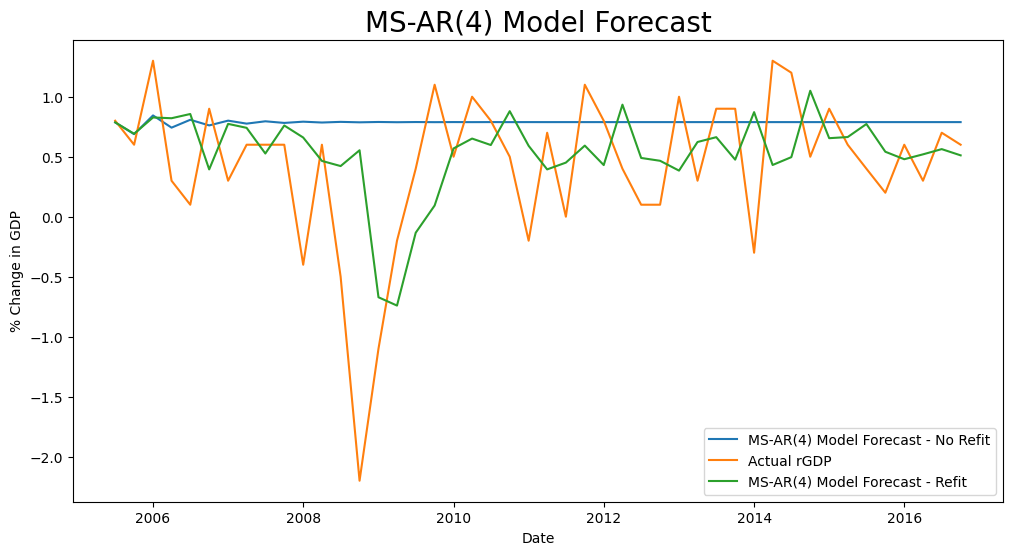

In [ ]:
# Plotting
plt.figure(figsize=(12, 6))
plt.title("MS-AR(4) Model Forecast", fontsize=20)
plt.plot(df_test.index, y[lags:], label='MS-AR(4) Model Forecast - No Refit')
plt.plot(df_test['rGDP'], label='Actual rGDP')
plt.plot(df_predictions_ms_refit['prediction'], label='MS-AR(4) Model Forecast - Refit')
plt.xlabel("Date")
plt.ylabel("% Change in GDP")
plt.legend()
plt.show()

In [ ]:
print('2-Norm Error: ', np.linalg.norm(df_predictions_ms_refit['prediction'].values - df_test['rGDP'].values))

2-Norm Error:  4.38266698667417
